In [1]:
import sys
sys.path.append('../.') 

# BIBLIOTEKI
import pandas as pd
from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.embedders import CountEmbedder
from src.embedders.osm_data_embedder import OSMDataEmbedder
from sklearn.preprocessing import LabelEncoder
import torch
from src.graph.create_graph import OSMEmbedderGraph

from src.baseline_models.GCN.supervised_node_classification import SupervisedNodeClassificationGNN
from src.baseline_models.GCN.GraphData import GraphData
from src.baseline_models.GCN.gcn import GCNModel

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

import pandas as pd
import torch


from src.baseline_models.classifier import CustomClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Podział mapy Wrocławia na obszary, zliczenie danych cech w obszarze, połączenie X z Y (Y - liczba wypadów w danym obszarze)

area = geocode_to_region_gdf("Wrocław, Poland")
regionalizer = H3Regionalizer(resolution=8)
embedder = CountEmbedder()
query = {"highway": True}

embeddings = OSMDataEmbedder(area=area, embedder=embedder, regionalizer=regionalizer, query=query)
embeddings_feature_gdf = embeddings.make_embeddings()

df_accidents = pd.read_csv('../data/embeddings.csv')

gdf = pd.merge(embeddings_feature_gdf, df_accidents, on='region_id', how='inner')

In [4]:
# Stworzenie etykiet określających poziom ryzyka na podstawie liczby wypadków + zakodowanie ich 

bins = [-1, 1, float("inf")]  # Bins: (-1, 0], (0, 2], (2, 12], (12, inf)
label_names = ['no risk', 'risk']
gdf['risk_level'] = pd.cut(gdf['rok_2023'], bins=bins, labels=label_names, right=True)

labels = gdf['risk_level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

gdf['risk_level'] = labels_encoded
gdf= gdf.set_index('region_id')
gdf = gdf.drop(['rok_2023'], axis=1)
gdf.head(3)

,geometry,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level
region_id,,,,,,,,,,,,,,,,,,,,,
881e20422bfffff,"POLYGON ((16.91058 51.15870, 16.90817 51.15442...",0,2,0,0,6,4,0,72,0,...,0,31,0,0,0,0,2,0,0,1
881e2042c7fffff,"POLYGON ((16.99075 51.16618, 16.98834 51.16190...",0,3,0,0,3,0,0,18,0,...,0,8,14,0,0,0,0,0,0,0
881e2040c3fffff,"POLYGON ((17.01939 51.11909, 17.01697 51.11481...",0,8,0,0,55,29,0,499,0,...,4,0,0,20,0,0,1,0,8,1


In [5]:
(gdf.risk_level ==1).sum()

236

In [6]:
# Wybór cech + stworzenie bazowego gdf 

selected_features = ['highway_bridleway',
 'highway_bus_stop',
 'highway_elevator',
 'highway_give_way',
 'highway_motorway',
 'highway_passing_place',
 'highway_primary_link',
 'highway_secondary_link',
 'highway_stop',
 'highway_traffic_signals',
 'highway_turning_circle']

gdf_base = gdf[['geometry']+selected_features+['risk_level']]
gdf_base.head(3)

,geometry,highway_bridleway,highway_bus_stop,highway_elevator,highway_give_way,highway_motorway,highway_passing_place,highway_primary_link,highway_secondary_link,highway_stop,highway_traffic_signals,highway_turning_circle,risk_level
region_id,,,,,,,,,,,,,
881e20422bfffff,"POLYGON ((16.91058 51.15870, 16.90817 51.15442...",0,2,0,0,0,0,0,0,0,0,2,1
881e2042c7fffff,"POLYGON ((16.99075 51.16618, 16.98834 51.16190...",0,3,0,0,0,1,0,0,0,0,0,0
881e2040c3fffff,"POLYGON ((17.01939 51.11909, 17.01697 51.11481...",0,8,0,0,0,0,0,3,0,20,1,1


In [7]:
# Tworzenie obiektu Data z torch_geometric
G = OSMEmbedderGraph(gdf_base, "risk_level",  'shortest_path')
data = G.createGraph_Data()

Statistics:
--------------------------------------------------
Nodes:  422
Edges:  88831
Nodes dim:  11
Nodes class 2
Directed:  False
Graph density:  100.0 %


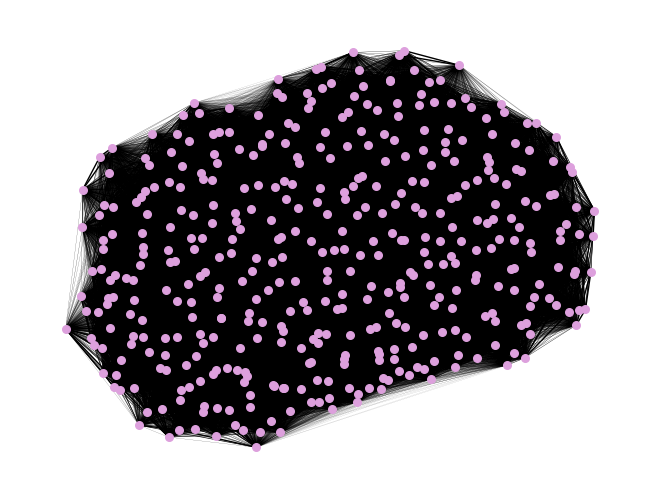

In [8]:
# Wświetlenie grafu + statystkiki 
G.show_statistics() 
G.graph_visualization() 

---

In [9]:
import pytorch_lightning as pl
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import torch
from torch import nn
from torch_geometric.data import Data
from typing import List, Optional, Tuple
from sklearn.decomposition import PCA
# import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## GCN model

In [10]:
num_features = data.num_features
hidden_dim = 256
out_dim = 128
num_classes = len(data.y.unique())

gnn = GCNModel(in_dim=num_features, hidden_dim=hidden_dim, out_dim=out_dim)

model = SupervisedNodeClassificationGNN(gnn=gnn, emb_dim=out_dim, num_classes=num_classes, lr=0.0001)

In [11]:
data

Data(edge_index=[2, 177662], weight=[177662], num_nodes=422, x=[422, 11], y=[422])

In [12]:
type(data)

torch_geometric.data.data.Data

In [13]:
type(gdf_base.index.to_numpy())

numpy.ndarray

In [14]:
nodes_labels = {'node': gdf_base.index.to_numpy(), 'label': data.y.cpu().numpy()}
df_to_split = pd.DataFrame(nodes_labels)

df_train, df_test = train_test_split(df_to_split, test_size=0.2, random_state=42, stratify=df_to_split['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['label'])

train_nodes = df_train['node']
val_nodes = df_val['node']
test_nodes = df_test['node']

train_mask = []   
val_mask = []
test_mask = []

for i in range(len(data.y)):

  if i in train_nodes:
    train_mask.append(True)
    val_mask.append(False)
    test_mask.append(False)
  elif i in val_nodes:
    train_mask.append(False)
    val_mask.append(True)
    test_mask.append(False)
  elif i in test_nodes:
    train_mask.append(False)
    val_mask.append(False)
    test_mask.append(True)

data.train_mask = torch.tensor(train_mask).cpu()
data.val_mask = torch.tensor(val_mask).cpu()
data.test_mask = torch.tensor(test_mask).cpu()

In [15]:
from pytorch_lightning.callbacks import ProgressBar
class LitProgressBar(ProgressBar):

    def __init__(self):
        super().__init__()  # don't forget this :)
        self.enable = True

    def disable(self):
        self.enable = False

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx)  # don't forget this :)
        percent = (batch_idx / self.total_train_batches) * 100
        sys.stdout.flush()
        sys.stdout.write(f'{percent:.01f} percent complete \r')

bar = LitProgressBar()
bar.disable()

In [16]:
# Trenowanie modelu

trainer = pl.Trainer(max_epochs=15, callbacks=[bar])
datamodule = GraphData([data])
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_floa

/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-

/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-

/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-

/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/b/gradient/gradient/env/lib/python3.10/site-

---

### Results

In [17]:
trainer.test(model=model, datamodule=datamodule, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[{'step': 15.0,
  'test/auc_weighted': 0.7171052694320679,
  'test/f1_weighted': 0.3998611569404602,
  'test/precision_weighted': 0.3115197420120239,
  'test/recall_weighted': 0.5581395626068115,
  'test/accuracy_weighted': 0.5581395626068115}]

In [18]:
test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc_weighted"]

z, y, y_pred = trainer.predict(model=model, datamodule=datamodule)[0]

print(f'AUC test = {test_auc * 100.:.2f}[%]')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AUC test = 71.71[%]


/mnt/b/gradient/gradient/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


In [19]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
y_pred_test = y_pred[test_mask]

In [21]:
import geopandas as gpd

In [22]:
regions_gdf: gpd.GeoDataFrame = regionalizer.transform(area)
regions_gdf

,geometry
region_id,
881e20422bfffff,"POLYGON ((16.91058 51.15870, 16.90817 51.15442..."
881e2042c7fffff,"POLYGON ((16.99075 51.16618, 16.98834 51.16190..."
881e2040c3fffff,"POLYGON ((17.01939 51.11909, 17.01697 51.11481..."
881e205561fffff,"POLYGON ((16.95215 51.20788, 16.94974 51.20361..."
881e20425bfffff,"POLYGON ((16.94491 51.19506, 16.94249 51.19078..."
...,...
881e204285fffff,"POLYGON ((16.99610 51.15120, 16.99369 51.14693..."
881e2042a9fffff,"POLYGON ((16.98618 51.14586, 16.98376 51.14158..."
881e204669fffff,"POLYGON ((17.12598 51.18530, 17.12355 51.18103..."


In [23]:
from src.utils.hex_visualization import visualize_predictions

visualize_predictions(df_test, y_pred_test, regions_gdf)

No false negatives


---

## Linear Regression

In [27]:
train_nodes_array = df_train.index
X_train = data.x[train_nodes_array].cpu().numpy()
y_train = df_train['label'].values

test_nodes_array = df_test.index
X_test = data.x[test_nodes_array].cpu().numpy()
y_test = df_test['label'].values


In [28]:
logistic_reg = CustomClassifier()
logistic_reg.train(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

In [29]:
y_pred

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [31]:
y_test

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [32]:
X_test

array([[ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  5.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.],
       [ 0., 15.,  7.,  1.,  0.,  0.,  0.,  0.,  0., 28.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  3.,  0.,  0.,  0.,  0.,  0

In [37]:
metrics, conf_matrix_disp = logistic_reg.evaluate(X_test, y_test, y_pred)
metrics

{'F1 Score': 0.8609201213346814,
 'Accuracy': 0.8604651162790697,
 'Precision': 0.8650961441659116,
 'Recall': 0.8604651162790697,
 'AUC Score': 0.8991228070175439}

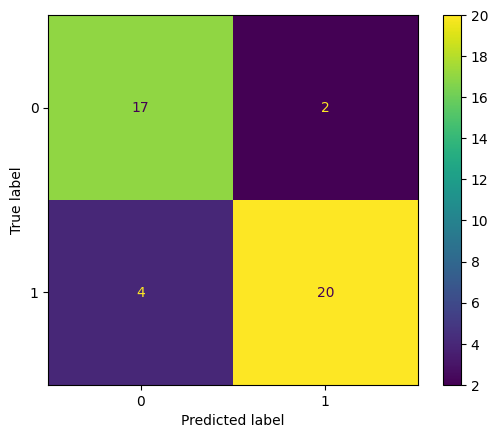

In [36]:
conf_matrix_disp.plot()